In [1]:
import matplotlib
matplotlib.__version__


'2.2.2'

In [2]:
# %load churnlab_utils.py
import pandas as pd
import numpy as np
from sklearn.cluster import DBSCAN
from itertools import compress
import itertools
import numpy as np
import matplotlib.pyplot as plt
from sklearn import svm, datasets
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
import math
from sklearn.tree import DecisionTreeClassifier 
from sklearn.model_selection import cross_val_score
from sklearn.metrics import accuracy_score
import tensorflow as tf
	
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    import matplotlib.pyplot as plt
    import numpy as np
    plt.imshow(cm, interpolation='nearest', cmap=cmap,aspect='auto')
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")
    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.savefig('confusion_mat.png', bbox_inches='tight', format='png', dpi=300, pad_inches=0,transparent=True)
    plt.show()
    return
	
def pdutil_describeItemRange(df):  # Show the number of unique values in each column
    """pdutil_describeItemRange performs is similar to descrive for a DataFrame"""
    """but it displays the number of unique values in each column"""
    """argument is a dataFrame """
    """return is smaller dataFrame with the same columns as the original"""
    cols = df.columns.tolist()
    vals = pd.DataFrame ( [ len(set(df[s])) for s in df.columns.tolist()] ).T
    vals.columns = cols
    return vals

def pdutil_factorize(df):
    """pdutil_factorize performs converts every categorical column in a dataFrame to numeric values"""
    """pass in a DataFrame"""
    """return value is a similar dataFrame but with categorical values converted to numbers"""    
    return  df.apply(lambda x: pd.factorize(x)[0])

def pdutil_OneHotEncode(pdold, StaticCols, EncodeCols):
    """pdutil_OneHotEncode performs OneHotEncoding on specified columns in our dataframe"""
    """pdold is the old dataframe we are paasing in"""
    """StaticCols is a list of columns we do not wish to encode"""
    """EncodeCols is a list of columns we wish to encode"""
    """Returns a modified DataFrame with oneHotEncoded columns"""
    # make sure that we our static list is not in our encode list
    cols_OneHotEncode = sorted(list(set(EncodeCols) - set(StaticCols)))
    # create a new dataframe which represents the static columns
    pdnew = pdold[StaticCols]
    # loop thru the endcode list and OneHotEncode (using get_dummies) each column in the encode list
    # note - this will typically map a single column to several columns - one for each value contained in the original column
    for col in cols_OneHotEncode:
        new_names = []
        enc = pd.get_dummies(pdold[col])
        for subcol in  enc:
            name = col + str(subcol)
            new_names.append(name)
        enc.columns = new_names
        # concat the new OneHotEnoded dataframe to the original
        pdnew = pd.concat([pdnew, enc], axis=1)
    return pdnew


def pdutil_dbscan(df, eps_):
# Compute DBSCAN
    labels = []
    db = DBSCAN(eps=eps_, min_samples=100).fit(df)
    labels = pd.DataFrame(db.labels_ )
    #n_clusters_ = labels[0].madf()
    n_clusters_ = len(list(set(db.labels_))) - (1 if -1 in db.labels_ else 0)
    # Number of clusters in labels, ignoring noise if present.
    tdft = 'dbsPCA'
    df[tdft]=labels
    print('eps:{} Estimated number of clusters: {}'.format(eps_, n_clusters_) ) 
    return df, labels, n_clusters_

## import tensorflow as tf
import numpy as np
import pandas as pd
import math

from sklearn.tree import DecisionTreeClassifier 
from sklearn.model_selection import cross_val_score
from sklearn.metrics import accuracy_score
import tensorflow as tf
import numpy as np

CLASS_SIZE = 2
#DATA_SIZE = 0

def load_csv(filename):
    file = pd.read_csv(filename, header=0)

    # get sample's metadata
    n_samples = int(file.columns[0])
    n_features = int(file.columns[1])

    # divide samples into explanation variables and target variable
    data = np.empty((n_samples, n_features))
    target = np.empty((n_samples,), dtype=np.int)
    for i, row in enumerate(file.itertuples()):
        target[i] = np.asarray(row[-1], dtype=np.int)
        data[i] = np.asarray(row[1:n_features+1], dtype=np.float64)
    return (data, target)

# output train data 
def get_batch_data(x_train, y_train, size=None):
    if size is None:
        size = len(x_train)
    batch_xs = x_train
    batch_ys = []

    # convert to 1-of-N vector
    for i in range(len(y_train)):
        val = np.zeros((CLASS_SIZE), dtype=np.float64)
        val[y_train[i]] = 1.0
        batch_ys.append(val)
    batch_ys = np.asarray(batch_ys)
    return batch_xs[:size], batch_ys[:size]

# output test data
def get_test_data(x_test, y_test):
    batch_ys = []

    # convert to 1-of-N vector
    for i in range(len(y_test)):
        val = np.zeros((CLASS_SIZE), dtype=np.float64)
        val[y_test[i]] = 1.0
        batch_ys.append(val)
    return x_test, np.asarray(batch_ys)

# for parameter initialize
def get_stddev(in_dim, out_dim):
    return 1.3 / math.sqrt(float(in_dim) + float(out_dim))

# DNN Model Class
class Classifier:
    def __init__(self, hidden_units=[10], n_classes=0, data_size = 0):
        self._hidden_units = hidden_units
        self._n_classes = n_classes
        self._data_size = data_size
        self._sess = tf.Session()

    # build model
    def inference(self, x):
        hidden = []

        # Input Layer
        with tf.name_scope("input"):
            weights = tf.Variable(tf.truncated_normal([self._data_size , self._hidden_units[0]], stddev=get_stddev(self._data_size, self._hidden_units[0]), seed=42), name='weights')
            biases = tf.Variable(tf.zeros([self._hidden_units[0]]), name='biases')
            input = tf.matmul(x, weights) + biases

        # Hidden Layers
        for index, num_hidden in enumerate(self._hidden_units):
            if index == len(self._hidden_units) - 1: break
            with tf.name_scope("hidden{}".format(index+1)):
                weights = tf.Variable(tf.truncated_normal([num_hidden, self._hidden_units[index+1]], seed=42, stddev=get_stddev(num_hidden, self._hidden_units[index+1])), name='weights')
                biases = tf.Variable(tf.zeros([self._hidden_units[index+1]]), name='biases')
                inputs = input if index == 0 else hidden[index-1]
                hidden.append(tf.nn.relu(tf.matmul(inputs, weights) + biases, name="hidden{}".format(index+1)))
        
        # Output Layer
        with tf.name_scope('output'):
            weights = tf.Variable(tf.truncated_normal([self._hidden_units[-1], self._n_classes], seed=42, stddev=get_stddev(self._hidden_units[-1], self._n_classes)), name='weights')
            biases = tf.Variable(tf.zeros([self._n_classes]), name='biases')
            logits = tf.nn.softmax(tf.matmul(hidden[-1], weights) + biases)

        return logits

    # loss function
    def loss(self, logits, y):        
        #return -tf.reduce_mean(y * tf.log(logits))
        return tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(logits=logits, labels=y))

    # fitting function for train data
    def fit(self, x_train=None, y_train=None, steps=200):
        # build model
        x = tf.placeholder(tf.float32, [None, self._data_size ])
        y = tf.placeholder(tf.float32, [None, CLASS_SIZE])
        logits = self.inference(x)
        loss = self.loss(logits, y)
        train_op = tf.train.AdamOptimizer(0.003).minimize(loss)

        # save variables
        self._x = x
        self._y = y
        self._logits = logits
 
        # init parameters
        #init = tf.initialize_all_variables() 
        init = tf.global_variables_initializer()
        self._sess.run(init)

        # train
        for i in range(steps):
            batch_xs, batch_ys = get_batch_data(x_train, y_train)
            self._sess.run(train_op, feed_dict={x: batch_xs, y: batch_ys})

    # evaluation function for test data
    def evaluate(self, x_test=None, y_test=None):
        x_test, y_test = get_test_data(x_test, y_test)
        
        # build accuracy calculate step
        correct_prediction = tf.equal(tf.argmax(self._logits, 1), tf.argmax(self._y, 1))
        accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))

        # evaluate
        return self._sess.run([accuracy], feed_dict={self._x: x_test, self._y: y_test})

    # label prediction
    def predict(self, samples):
        predictions = tf.argmax(self._logits, 1)
        return self._sess.run(predictions, {self._x: samples})


# Let's Explore Some Telco Churn Data

Data can be found here WA_Fn-UseC_-Telco-Customer-Churn.csv: https://community.watsonanalytics.com/wp-content/uploads/2015/03/WA_Fn-UseC_-Telco-Customer-Churn.csv

# What’s in the Telco Customer Churn data set?
This data set provides info to help you predict behavior to retain customers. You can analyze all relevant customer data and develop focused customer retention programs.

A telecommunications company is concerned about the number of customers leaving their landline business for cable competitors. They need to understand who is leaving. Imagine that you’re an analyst at this company and you have to find out who is leaving and why.

The data set includes information about:
* Customers who left within the last month – the column is called Churn
* Services that each customer has signed up for – phone, multiple lines, internet, online security, online backup, device protection, tech support, and streaming TV and movies
* Customer account information – how long they’ve been a customer, contract, payment method, paperless billing, monthly charges, and total charges
* Demographic info about customers – gender, age range, and if they have partners and dependents



# Choose interactive or inline plotting

In [3]:
#%matplotlib notebook


In [4]:
import pandas as pd
import numpy as np
%matplotlib inline
# Added to support multiple environments
!wget https://community.watsonanalytics.com/wp-content/uploads/2015/03/WA_Fn-UseC_-Telco-Customer-Churn.csv
nimbix = False
if(nimbix) :
    churn = pd.read_csv('/data/datasets/WA_Fn-UseC_-Telco-Customer-Churn.csv')
else :
    churn = pd.read_csv('WA_Fn-UseC_-Telco-Customer-Churn.csv')

churn.head()

--2018-07-23 22:13:24--  https://community.watsonanalytics.com/wp-content/uploads/2015/03/WA_Fn-UseC_-Telco-Customer-Churn.csv
Resolving community.watsonanalytics.com (community.watsonanalytics.com)... 158.85.2.14
Connecting to community.watsonanalytics.com (community.watsonanalytics.com)|158.85.2.14|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 977501 (955K) [text/csv]
Saving to: ‘WA_Fn-UseC_-Telco-Customer-Churn.csv.22’

100%[======================================>] 977,501     1.16MB/s   in 0.8s   

2018-07-23 22:13:25 (1.16 MB/s) - ‘WA_Fn-UseC_-Telco-Customer-Churn.csv.22’ saved [977501/977501]



,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,...,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,7590-VHVEG,Female,0,Yes,No,1,No,No phone service,DSL,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,29.85,29.85,No
1,5575-GNVDE,Male,0,No,No,34,Yes,No,DSL,Yes,...,Yes,No,No,No,One year,No,Mailed check,56.95,1889.5,No
2,3668-QPYBK,Male,0,No,No,2,Yes,No,DSL,Yes,...,No,No,No,No,Month-to-month,Yes,Mailed check,53.85,108.15,Yes
3,7795-CFOCW,Male,0,No,No,45,No,No phone service,DSL,Yes,...,Yes,Yes,No,No,One year,No,Bank transfer (automatic),42.30,1840.75,No
4,9237-HQITU,Female,0,No,No,2,Yes,No,Fiber optic,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,70.70,151.65,Yes


# Handy Utilities

In [5]:
from itertools import compress
from churnlab_utils import pdutil_describeItemRange
from churnlab_utils import pdutil_factorize
from churnlab_utils import pdutil_OneHotEncode
from churnlab_utils import pdutil_dbscan
from churnlab_utils import plot_confusion_matrix
from churnlab_utils import Classifier
        
def bobHeatmap(df,sortColumn):
    import matplotlib.pyplot as plt
    import matplotlib.pyplot as plt
    import seaborn as sns
    
    df = (df - df.min(0)) / (df.max(0) -df.min(0))

    plt.figure(figsize=(20, 10))
    
    CMAP = "gist_heat"
    #CMAP = "gist_ncar"
    
    if(sortColumn not in df.columns): # check if a sort column was passed in
        ax = sns.heatmap(df, yticklabels = 1000, cmap=CMAP, center = 1)
    else:
        ax = sns.heatmap(df.sort_values(by=[sortColumn]), yticklabels = 1000, cmap=CMAP, center = 1)
    #ax = sns.heatmap(df, yticklabels = 1000, cmap=CMAP, center = 1)

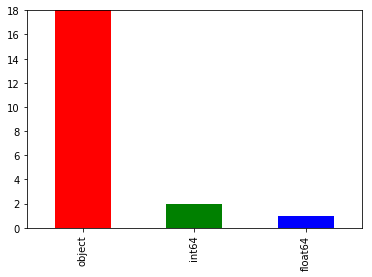

In [6]:
import pandas as pd
import numpy as np
# Added to support multiple environments
nimbix = False
if(nimbix) :
    churn = pd.read_csv('/data/datasets/WA_Fn-UseC_-Telco-Customer-Churn.csv')
else :
    churn = pd.read_csv('WA_Fn-UseC_-Telco-Customer-Churn.csv')

plt.ylim(0,18, 1)
pd.DataFrame(churn.dtypes,columns=['objectType']).objectType.value_counts().plot(kind='bar', color = 'rgbkymc' )
#myhist.objectType.value_counts().plot(kind='bar')


# Some Cleaning Required       :-)
In reality, on **real datasets**, this takes on the order of **80%** of datascientist time.

For this dataset, TotalCharges is an object rather than a float64. We will convert it to float64 and **force any non numeric items** to be imputed with the **mean**.

Other methods might interpolate a missing value using a linear interpolation, or use the max value, or in some cases drop these instances or dro the feature - it all depends on the data.

# Artifically force dirty the data to make a point

We will inject None, NaN, Inf into various columns to demonstrate what non-cleaned data might look like. 

This will motivate our examples of detecting and cleaning this kind of data


In [7]:
# Data was too clean - lets artifically inject some NULL data to see how to detect the,m in later steps

nullmask1 = [5, 47, 1962, 1987, 1991, 1994, 2018]
nullmask2 = [2, 4, 7, 10, 13, 16, 19, 22, 25, 28, 31]
nullmask3 = [3,13,23]
churn.SeniorCitizen[nullmask1] = None
churn.TotalCharges[nullmask2] = float('NaN')
churn.MonthlyCharges[nullmask3] = float('Inf')

/usr/local/src/bluemix_jupyter_bundle.v95/notebook/lib/python2.7/site-packages/ipykernel/__main__.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/usr/local/src/bluemix_jupyter_bundle.v95/notebook/lib/python2.7/site-packages/ipykernel/__main__.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/usr/local/src/bluemix_jupyter_bundle.v95/notebook/lib/python2.7/site-packages/ipykernel/__main__.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


# Determine how many NaN's, None's, Inf's exist in the data

This can be done for the entire data set or on a column by column basis

In [8]:
pd.options.mode.use_inf_as_null = True
#churn.apply(pd.Series.nunique)   # cardinality
churn.isnull().sum().sum()  # count Nan's in entire dataframe|
#churn.isnull().sum()   # count Nan's by column


21

## Determine Where the NaN's are: Bar Chart of Frequencies

Here we use a variation of a histogram, implenmented as a bar plot, to count the frequencies of NaN's in our data set for each column.

Nan's must be delat with prior to any modelling

/gpfs/fs01/user/s37a-6a8375ad9b78b5-6459f7095f24/.local/lib/python2.7/site-packages/matplotlib/font_manager.py:1328: UserWarning: findfont: Font family [u'sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


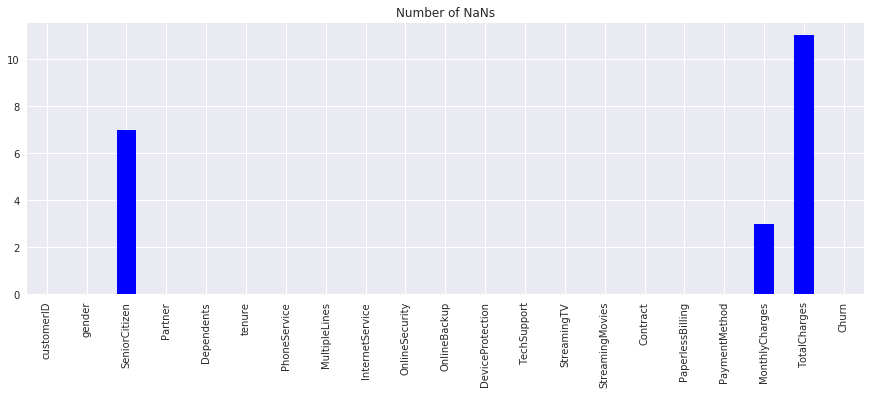

In [9]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(15, 5))
churn.isnull().sum().plot(kind='bar', title='Number of NaNs')


## Correct Nan's or Reload the dataset 

Reloading the data to undo the Nan experiment from above

In [10]:
churn[['TotalCharges']] = churn[['TotalCharges']].apply(pd.to_numeric, errors='coerce') 
churn["TotalCharges"].fillna(churn["TotalCharges"].mean(), inplace=True)

churn[['SeniorCitizen']] = churn[['SeniorCitizen']].apply(pd.to_numeric, errors='coerce') 
churn["SeniorCitizen"].fillna(churn["SeniorCitizen"].mean(), inplace=True)

churn.MonthlyCharges.replace(np.inf, 0, inplace=True)

churn[['MonthlyCharges']] = churn[['MonthlyCharges']].apply(pd.to_numeric, errors='coerce') 
churn["MonthlyCharges"].fillna(churn["MonthlyCharges"].mean(), inplace=True)

#if(nimbix) :
#    churn = pd.read_csv('/data/datasets/WA_Fn-UseC_-Telco-Customer-Churn.csv')
#else :
#    churn = pd.read_csv('WA_Fn-UseC_-Telco-Customer-Churn.csv')


# Describe the Range of Values in each Column
The is an important step in understanding your data. Not only should I have an understanding of the size and shape of my data, the number of rows and columns, but also how many unique values each column may take on. This is important for upcoming steps where we encode the data for consumption by a model. knowing how many possible values can influence the choice of encodig such one-hot-encoding verus binning for example. For classification purposes, the categorical values (most of the entirety of this table) have 2 to 4 possible values and might be candidates for one-hot-encoding or similar encodings.  But MonthlyCharges and TotalCharges, if manipulated at all, might benefit from binning, since this is more of a continous varibale and not categorical.

In [11]:
pdutil_describeItemRange(churn)
#churn.describe()

,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,...,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,7043,2,3,2,2,73,2,3,3,3,...,3,3,3,3,3,2,4,1585,6522,2


## Explore the Cardinality of the Dataset Visually

Here we explore the cardinality of the data - how many varieties of values are ther in each column.

Categorical data hopefully will have a handful of values, numeric data will likely have many attainable values.

This step is for sanity checking. Do expect a smaller number of choices for a given column to be able to acquire?

What if the categorical data has huge cardinality? FOr example, zip codes have huge cardinality. Some researchers recommend 

replacing zip code with a numerica vlaue that represents a presentage - such as perentage of each zip codes contribution to sales, 

or percentage of of occurences of that zip code out of all zip codes

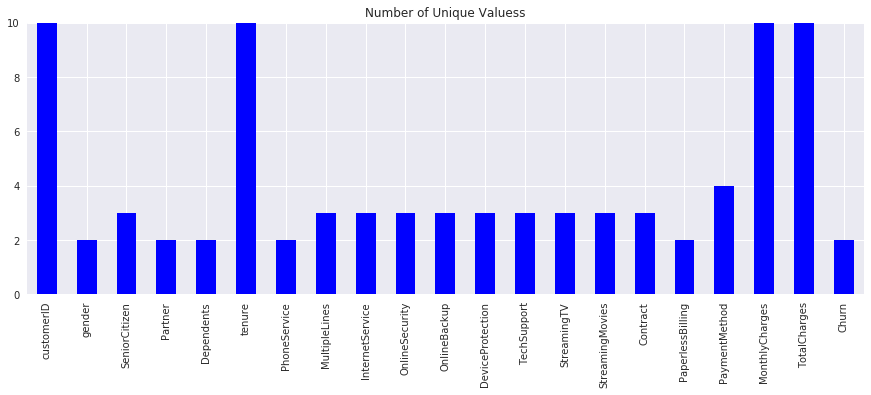

In [12]:
plt.figure(figsize=(15, 5))
churn.apply(pd.Series.nunique).plot(kind='bar', title='Number of Unique Valuess', ylim=(0,10) )

In [13]:
churn[['TotalCharges']] = churn[['TotalCharges']].apply(pd.to_numeric, errors='coerce') 
#churn["TotalCharges"].fillna(churn["TotalCharges"].mean(), inplace=True)

## Break Dataset into Two Parts: Categorical, and Numeric

In [14]:
# here are the columns which are categorical
churn_cat_col = [key for key in dict(churn.dtypes) if dict(churn.dtypes)[key] in ['object']]
# here are the columns which are numeric
churn_num_col = [key for key in dict(churn.dtypes) if dict(churn.dtypes)[key] in ['float64', 'int64']]
#create a dataframe to hold categorical data
churn_cat = churn[churn_cat_col]
#create a dataframe to hold numeric data
churn_num = churn[churn_num_col]
# display first few rows of numerical data to get a feel for them
print churn_num.head()
# display first few rows of categorical data to get a feel for them
churn_cat.head()

   SeniorCitizen  MonthlyCharges  tenure  TotalCharges
0              0           29.85       1     29.850000
1              0           56.95      34   1889.500000
2              0           53.85       2   2284.431783
3              0            0.00      45   1840.750000
4              0           70.70       2   2284.431783


,Churn,DeviceProtection,TechSupport,OnlineBackup,MultipleLines,gender,StreamingTV,Contract,StreamingMovies,PhoneService,PaperlessBilling,OnlineSecurity,Partner,Dependents,InternetService,PaymentMethod,customerID
0,No,No,No,Yes,No phone service,Female,No,Month-to-month,No,No,Yes,No,Yes,No,DSL,Electronic check,7590-VHVEG
1,No,Yes,No,No,No,Male,No,One year,No,Yes,No,Yes,No,No,DSL,Mailed check,5575-GNVDE
2,Yes,No,No,Yes,No,Male,No,Month-to-month,No,Yes,Yes,Yes,No,No,DSL,Mailed check,3668-QPYBK
3,No,Yes,Yes,No,No phone service,Male,No,One year,No,No,No,Yes,No,No,DSL,Bank transfer (automatic),7795-CFOCW
4,Yes,No,No,No,No,Female,No,Month-to-month,No,Yes,Yes,No,No,No,Fiber optic,Electronic check,9237-HQITU


In [15]:
churn_num.describe()

,SeniorCitizen,MonthlyCharges,tenure,TotalCharges
count,7043.000000,7043.000000,7043.000000,7043.000000
mean,0.162308,64.732458,32.371149,2284.431783
std,0.368576,30.114889,24.559481,2263.362305
min,0.000000,0.000000,0.000000,18.800000
25%,0.000000,35.450000,9.000000,403.250000
50%,0.000000,70.350000,29.000000,1405.300000
75%,0.000000,89.850000,55.000000,3780.625000
max,1.000000,118.750000,72.000000,8684.800000


# Convert Categories to Numbers

We apply the factorize function to all the categories as a first pass. We created a new dataframe here called **churn_cat_encode**

The commented out code would allow us to map back to the original form if needed

PaymentMethod for example will now have numeric values like 0, 1, 2, 3,...:


In [16]:
#  pd_factorize the categorical churn columns
churn_cat_encode = pdutil_factorize(churn_cat)
churn_cat_encode.head()

,Churn,DeviceProtection,TechSupport,OnlineBackup,MultipleLines,gender,StreamingTV,Contract,StreamingMovies,PhoneService,PaperlessBilling,OnlineSecurity,Partner,Dependents,InternetService,PaymentMethod,customerID
0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,0,1,0,1,1,1,0,1,0,1,1,1,1,0,0,1,1
2,1,0,0,0,1,1,0,0,0,1,0,1,1,0,0,1,2
3,0,1,1,1,0,1,0,1,0,0,1,1,1,0,0,2,3
4,1,0,0,1,1,0,0,0,0,1,0,0,1,0,1,0,4


In [17]:
#churn.groupby('TechSupport').count()

In [18]:
churn_cat_encode.groupby('TechSupport').count()

,Churn,DeviceProtection,OnlineBackup,MultipleLines,gender,StreamingTV,Contract,StreamingMovies,PhoneService,PaperlessBilling,OnlineSecurity,Partner,Dependents,InternetService,PaymentMethod,customerID
TechSupport,,,,,,,,,,,,,,,,
0,3473,3473,3473,3473,3473,3473,3473,3473,3473,3473,3473,3473,3473,3473,3473,3473
1,2044,2044,2044,2044,2044,2044,2044,2044,2044,2044,2044,2044,2044,2044,2044,2044
2,1526,1526,1526,1526,1526,1526,1526,1526,1526,1526,1526,1526,1526,1526,1526,1526


In [19]:
# list of column name I wish to OneHotEncode
cols_OneHotEncode = ['DeviceProtection','TechSupport','OnlineBackup','MultipleLines','gender','StreamingTV','Contract','StreamingMovies','PhoneService','PaperlessBilling','OnlineSecurity','Partner','Dependents','InternetService','PaymentMethod']
# label is the column I ultimately want to predict aka Churn
label = churn_cat_encode['Churn']
# customer is the column representing the customerId
customer =  churn_cat_encode['customerID']
churn_encoded_numeric = pdutil_OneHotEncode (churn_cat_encode, [], cols_OneHotEncode)
churn_encoded_numeric = pd.concat([churn_encoded_numeric, churn_num], axis=1)  # add numeric to main df
churn_encoded_numeric.head()

,Contract0,Contract1,Contract2,Dependents0,Dependents1,DeviceProtection0,DeviceProtection1,DeviceProtection2,InternetService0,InternetService1,...,StreamingTV2,TechSupport0,TechSupport1,TechSupport2,gender0,gender1,SeniorCitizen,MonthlyCharges,tenure,TotalCharges
0,1,0,0,1,0,1,0,0,1,0,...,0,1,0,0,1,0,0,29.85,1,29.850000
1,0,1,0,1,0,0,1,0,1,0,...,0,1,0,0,0,1,0,56.95,34,1889.500000
2,1,0,0,1,0,1,0,0,1,0,...,0,1,0,0,0,1,0,53.85,2,2284.431783
3,0,1,0,1,0,0,1,0,1,0,...,0,0,1,0,0,1,0,0.00,45,1840.750000
4,1,0,0,1,0,1,0,0,0,1,...,0,1,0,0,1,0,0,70.70,2,2284.431783


# Encode the data (OneHotEncode)
The problem with the data above is that while the data are numeric, it give arbitrary low weights to categories encoded with 0 and higher weights to others

This will probably skew our analysis. For example, PaymentMethod has values 0, 1, 2.  Do we really mean to imply that PaymentMethod=0 has no weight, but PaymentMethod=2 has twice as much weight as PaymentMethod=1?

We use OneHotEncode here to make sure each value that was used is encoded with the value 1, while the value will be 0 if that feature was not used.

**Note:** We dont want to encode categories with many unique values in it such as customerID. 

We define a funvtion to handle doing the encoding for us

Now PaymentMethod will be split into brand new columns (one for each kind of numeric value) and each cell will have either 0 or 1, kind of like a check box, indicating the feature was present or not.

We also concatenate the previous numerica columns back in to have them available for analysis after standardization.

## Plotting One Hot Encoded Data is Problematic

You tend to get a few huge piles of dots that dont contribute much to understanding the data

### Plotting in 3D Won't Help Here Either

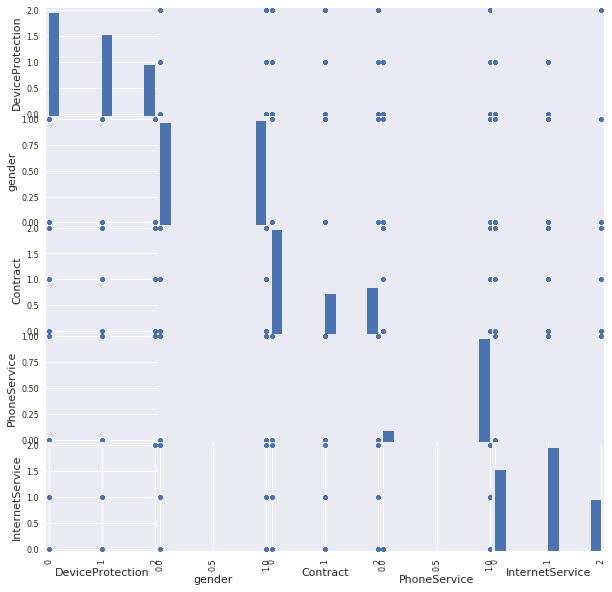

In [20]:
%matplotlib inline
from pandas import scatter_matrix
import matplotlib.pyplot as plt

cols_ = ['DeviceProtection','gender','Contract','PhoneService','InternetService']

scatter_matrix(churn_cat_encode[cols_], alpha=0.4, figsize=[10,10], grid=True)
plt.show()

# Standardize the Data

We scale and center the data around the mean. The reason is to make sure that each column gets a fair vote in the upcoming pca.  Without scaling, a column such as total_charges, with large range of values with larger absolute magnitude could dominate in PCA and effectively become the defacto largest pca component.

In [21]:
from sklearn import preprocessing
#scale our data to zero center it
scaler = preprocessing.StandardScaler().fit(churn_encoded_numeric)
X_scaled = preprocessing.scale(churn_encoded_numeric, with_mean=True, with_std=True )   # same as (df-df.mean())/df.std(ddof=0)

## Copy Churn Column to Encoded Dataframe
This dataframe has the same number of rows as the principal components Dataframe

They are parallel with each other

This copy step may be redundant since we copied Churn to the PCA Dataframe too, but it makes plotting more convenient

In [22]:
if 'Churn' not in churn_encoded_numeric.columns:
    churn_encoded_numeric = pd.concat([churn_encoded_numeric, label], axis=1)


# Correlation Plot
Plot shows which factors are correlated with which ohers and to what degree.

Here, red means highly correlated (as in correlated with Churn being bad therefor red), blue means negatively correlated, and white means no correlation.
**Notice** A customer with more contracts, more dependents, more tenure are less likley to churn in this example.

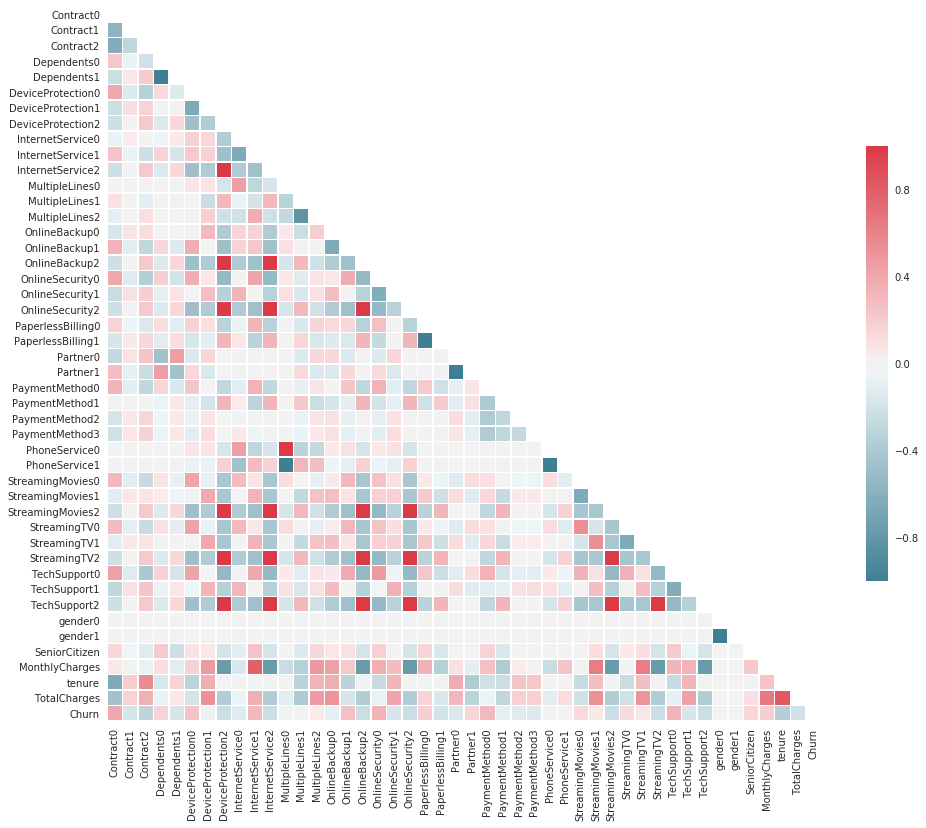

In [23]:
from string import ascii_letters
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

sns.set(style="white")

# Compute the correlation matrix
corr = churn_encoded_numeric.corr()

# Generate a mask for the upper triangle
mask = np.zeros_like(corr, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True

# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(16, 16))

# Generate a custom diverging colormap
cmap = sns.diverging_palette(220, 10, as_cmap=True)

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corr, mask=mask, cmap=cmap, vmax=.7, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5})

<h1><center>Principal Component Analysis To Analyze Bahavior</center></h1>

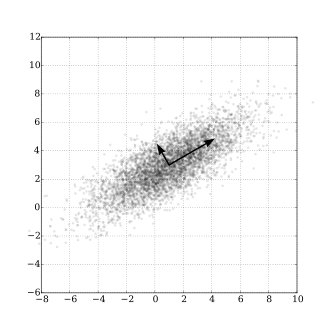

Principal component analysis (PCA) is a statistical procedure that uses an orthogonal transformation to convert a set of observations of possibly correlated variables into a set of values of linearly uncorrelated variables called principal components. The number of principal components is less than or equal to the number of original variables.




In [24]:
# display sorted eigenvalues
from sklearn.decomposition import PCA
scaler = preprocessing.StandardScaler().fit(churn_encoded_numeric.drop('Churn', axis=1))
X_scaled = preprocessing.scale(churn_encoded_numeric, with_mean=True, with_std=True )   # same as (df-df.mean())/df.std(ddof=0)
# start w n_components principal components and see how much variance that gives me
n_components = 20
# create instance of PCA (constructor)
pca = PCA(n_components=n_components)
#pca = PCA(copy=True, iterated_power='auto', n_components=n_components, random_state=None, svd_solver='auto', tol=0.0, whiten=False) 
pca.fit(X_scaled)
np_pcomps = pca.transform(X_scaled)  #get the actual principal components as vectors
print(pca.explained_variance_ratio_) 

[0.24842761 0.13510357 0.09331801 0.05528845 0.04969211 0.04352385
 0.0363804  0.03388936 0.02968084 0.02826922 0.02784344 0.02612758
 0.02529503 0.02460388 0.02318103 0.0214334  0.02010654 0.0191722
 0.01820003 0.01664218]


In [25]:
scaler

StandardScaler(copy=True, with_mean=True, with_std=True)

# Copy the PCA data to a Dataframe and print the top few rows

In [26]:
Col_headings = ['P'+str(x) for x in range(n_components)]
pcomps = pd.DataFrame(np_pcomps) 
pcomps.columns = Col_headings
# concatenate the Churn column on the end so its easy to plot by Churn
if 'Churn' not in pcomps.columns:
    pcomps = pd.concat([pcomps, label], axis=1)
pcomps.head()


,P0,P1,P2,P3,P4,P5,P6,P7,P8,P9,...,P11,P12,P13,P14,P15,P16,P17,P18,P19,Churn
0,-1.968681,-2.747834,4.725146,1.228740,2.765924,1.720818,-2.083150,-0.814524,1.572188,-1.193738,...,0.524880,0.227474,-0.330650,-1.059947,-0.402618,-0.026870,0.910675,-0.026903,-1.443894,0
1,-0.278500,-0.978381,2.011451,-1.213233,-3.506086,-1.679280,1.104794,0.761665,1.070117,2.187840,...,0.072127,1.395231,2.187767,0.283970,0.665850,-0.359030,0.834279,-0.775742,0.219552,0
2,-1.146662,-2.733011,1.029566,-1.132914,-2.202124,-1.290734,-0.724302,-2.139346,0.695458,-1.818325,...,-0.649813,1.721587,0.967308,0.700691,1.397111,-0.023309,0.135285,0.552179,-0.319500,1
3,-0.637056,0.063671,6.708676,1.973335,-1.558913,-1.457295,-0.460429,0.956567,0.170260,2.634067,...,0.127984,0.033638,0.944178,-0.136150,-1.700872,-0.034783,-1.670748,-0.182996,-0.279792,0
4,-2.149675,-4.113140,-1.426856,-0.534737,-0.191631,1.443313,0.030788,-0.639509,-0.209442,0.150772,...,0.427171,0.130745,-0.276266,0.083710,-1.161897,0.048315,-0.142753,-1.242717,-0.518840,1


# PCA Scree Plot

### Overview

A Scree Plot is a simple line segment plot that shows the fraction of total variance in the data as explained or represented by each PC. The PCs are ordered, and by definition are therefore assigned a number label, by decreasing order of contribution to total variance. The PC with the largest fraction contribution is labeled with the label name from the preferences file. Such a plot when read left-to-right across the abscissa can often show a clear separation in fraction of total variance where the 'most important' components cease and the 'least important' components begin. The point of separation is often called the 'elbow'.  (In the PCA literature, the plot is called a 'Scree' Plot because it often looks like a 'scree' slope, where rocks have fallen down and accumulated on the side of a mountain.)

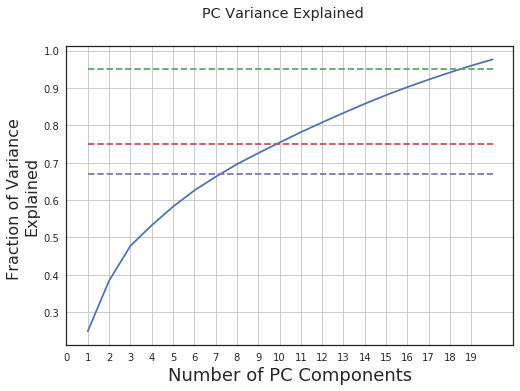

In [27]:
import matplotlib.pyplot as plt
import numpy as np

# bin is my x axis variable
bin = []
for i in range (n_components):
    bin.append(i+1)
# plot the cummulative variance against the index of PCA
cum_var = np.cumsum(pca.explained_variance_ratio_)
plt.plot(bin, cum_var)
# plot the 95% threshold, so we can read off count of principal components that matter
plt.plot(bin, [.95]*n_components, '--')
plt.plot(bin, [.75]*n_components, '--')
plt.plot(bin, [.67]*n_components, '--')
#turn on grid to make graph reading easier
plt.grid(True)
#plt.rcParams.update({'font.size': 24})
plt.suptitle('PC Variance Explained')
plt.xlabel('Number of PC Components', fontsize=18)
plt.ylabel('Fraction of Variance \nExplained', fontsize=16)
# control number of tick marks, 
plt.xticks([i for i in range(0,n_components)])
plt.show()

# Plot Principal Components: Scatter Matrix

Scatter Matrix using PCA allows us to see patterns visually. It helps to get a better feel for where you might want to drive and exploration

Control the **colors** by the ** churn variable** or by the cluster they are in

Get a feel for clsutering beahvior

* **black = no churn**

* **red = churn**

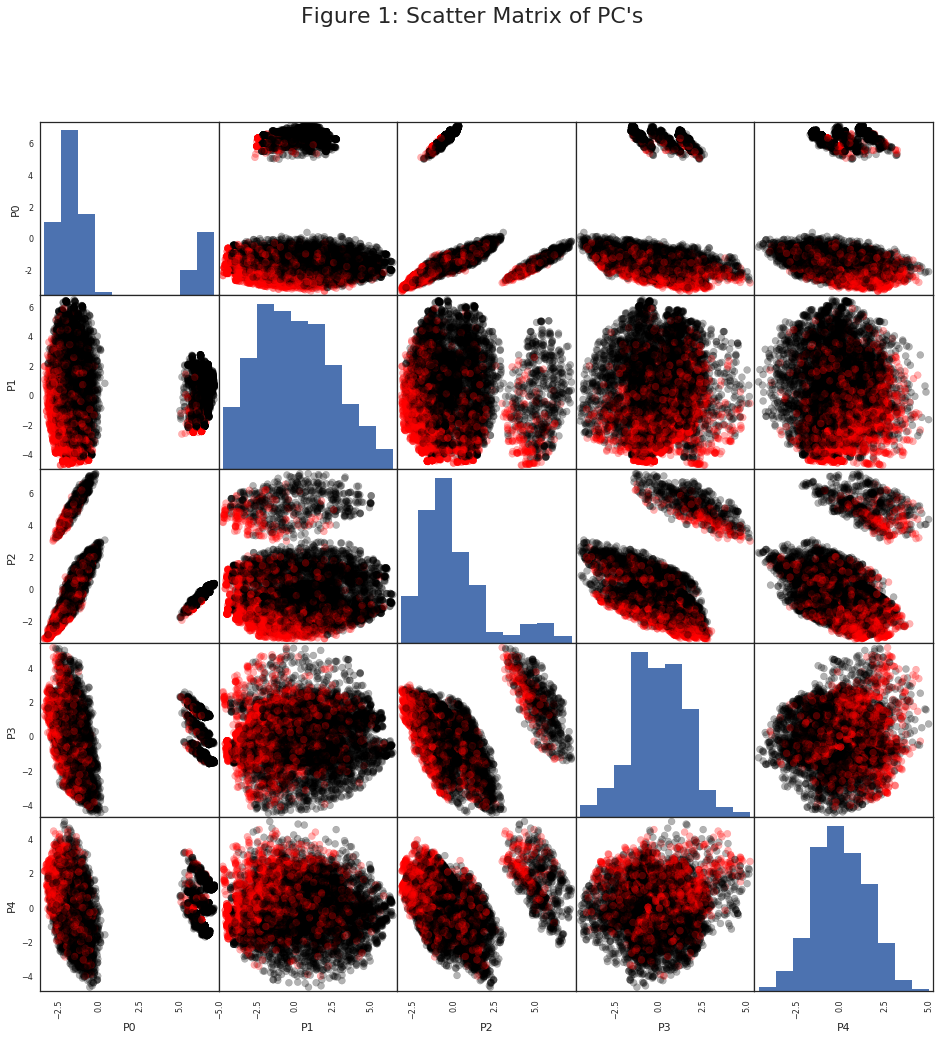

In [28]:
# from pandas.tools.plotting import scatter_matrix # For older versions of Pandas
from pandas import scatter_matrix
import matplotlib.pyplot as plt
%matplotlib inline

# Figure 1
# color the plot by the Churn variable
# attributes are the index of Principal components to plot against each other
attributes = [0, 1, 2, 3, 4]
#attributes = [item + 10 for item in attributes]   # mthod to add if you want to look at the least significant components
churn_colors=['black', 'red']  # colors to use to plot churners
# make a scatter plot
scatter_matrix(pcomps[attributes], alpha =.3, marker='o',c=pcomps.Churn.apply(lambda x:churn_colors[x]), figsize=[16,16])
#scatter_matrix(pcomps[attributes], alpha =.3, marker='x',c=churn_cat_encode_new2.InternetService0.astype('int').apply(lambda x:churn_colors[x]), figsize=[16,16])
#plt.rcParams.update({'font.size': 22})
plt.suptitle("Figure 1: Scatter Matrix of PC's", fontsize = 22)
plt.show()


## PCA notes

vertical clusters in columns such as those observed in P0 tend to not covary much with other other componets.  Clusters that align diagonally, say in plots P0 vs P4, indicate that the cluster varies with compenent 0 and 4 in a linear fashion and three bands indicates that there are three thresholds that govern the separtion of each the the three banded diagonal clusters. Coloring by our label could give us insight into which clusters to examine in more detail. For example, we can cut the tall vertical cluster in P0 out from the rest for deeper analysis.

## Method to Drill Down to Specific Portion of the Data
We are keying off the graph above and noticing that P0 < 0 covers a major portionof the clusters

So what makes this part of the tick?

In [29]:
churn_encoded_numeric[pcomps['P0']>0].describe()

,Contract0,Contract1,Contract2,Dependents0,Dependents1,DeviceProtection0,DeviceProtection1,DeviceProtection2,InternetService0,InternetService1,...,TechSupport0,TechSupport1,TechSupport2,gender0,gender1,SeniorCitizen,MonthlyCharges,tenure,TotalCharges,Churn
count,1537.000000,1537.000000,1537.000000,1537.000000,1537.000000,1537.000000,1537.000000,1537.000000,1537.000000,1537,...,1537.000000,1537.000000,1537.000000,1537.000000,1537.000000,1537.000000,1537.000000,1537.000000,1537.000000,1537.000000
mean,0.340924,0.240729,0.418347,0.574496,0.425504,0.003253,0.003904,0.992843,0.007157,0,...,0.002602,0.004554,0.992843,0.488614,0.511386,0.033938,21.362850,30.576448,684.335071,0.073520
std,0.474174,0.427665,0.493448,0.494580,0.494580,0.056962,0.062378,0.084322,0.084322,0,...,0.050965,0.067354,0.084322,0.500033,0.500033,0.180883,4.016227,24.333368,587.300571,0.261073
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,18.250000,0.000000,18.800000,0.000000
25%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0,...,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,19.700000,8.000000,162.150000,0.000000
50%,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0,...,0.000000,0.000000,1.000000,0.000000,1.000000,0.000000,20.150000,25.000000,532.100000,0.000000
75%,1.000000,0.000000,1.000000,1.000000,1.000000,0.000000,0.000000,1.000000,0.000000,0,...,0.000000,0.000000,1.000000,1.000000,1.000000,0.000000,20.950000,53.000000,1126.750000,0.000000
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,73.600000,72.000000,4097.050000,1.000000





# One Approach to Outliers (DBSCAN Visualization)

Control the **colors** by the **cluster** they are in

Get a feel for clsutering behavior

We added the cluster number to the dataframe so we can drill down as needed to examine a cluster in more detail.

When we create the model we might decide to take advantage of our feature engineering here or we might decide to let the ML/DL algorithm use all the data to make predictions.

**NOTE:** Be careful with relying on the cluster number. These were established by random selection. So each time we run we may get a different cluster number for what humans percieve as a clsuter or the k-means may find different clusters entirely. Specifying a random seed or using a different cluster methods, such SOM may make this part more rubust.

It would be great if we coudl isolate the different communities from each other and see if this effects the chrun prediction

For dbscan, when looking for outliers, I adjust the eps value to find a way to have a small number of clusters and the Outlier cluster (index = -1) be  on the order of 1% or 2% of the total number of observations





churnlab_utils.py:94: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  df[tdft]=labels


eps:4.2 Estimated number of clusters: 3
Outliers: 117:   Estimated number of clusters: 3


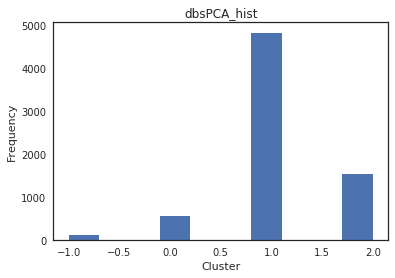

In [30]:
### import numpy as np
from sklearn.cluster import DBSCAN
from sklearn import metrics
from sklearn.preprocessing import StandardScaler

X = pcomps
eps = 4.2

number_of_eigens = 10
#subset_cols = X.columns[:10]
#pcomps2, labels, n_clusters = pdutil_dbscan(X[subset_cols], 4.2)  # call pd_dbscan with df=X, eps = 4.2

subset_cols = X.columns[:number_of_eigens] 
lst = subset_cols.tolist()

pcomps, labels, n_clusters = pdutil_dbscan(X[lst], eps)  # call pd_dbscan with df=X, eps = 4.2

dbsPCA_hist = pcomps.dbsPCA
print('Outliers: {}:   Estimated number of clusters: {}'.format(  dbsPCA_hist.tolist().count(-1),  n_clusters) )
plt.hist( dbsPCA_hist)
plt.title("dbsPCA_hist")
plt.xlabel("Cluster")
plt.ylabel("Frequency")
#plt.axis([-1,n_clusters,0,7200])
plt.show()

## Copying the dcscan column info for convenience

In [31]:
if 'dbsPCA' not in churn_encoded_numeric.columns:
    churn_encoded_numeric = pd.concat([churn_encoded_numeric, pcomps['dbsPCA']], axis=1)
churn_encoded_numeric.head()

,Contract0,Contract1,Contract2,Dependents0,Dependents1,DeviceProtection0,DeviceProtection1,DeviceProtection2,InternetService0,InternetService1,...,TechSupport1,TechSupport2,gender0,gender1,SeniorCitizen,MonthlyCharges,tenure,TotalCharges,Churn,dbsPCA
0,1,0,0,1,0,1,0,0,1,0,...,0,0,1,0,0,29.85,1,29.850000,0,0
1,0,1,0,1,0,0,1,0,1,0,...,0,0,0,1,0,56.95,34,1889.500000,0,1
2,1,0,0,1,0,1,0,0,1,0,...,0,0,0,1,0,53.85,2,2284.431783,1,1
3,0,1,0,1,0,0,1,0,1,0,...,1,0,0,1,0,0.00,45,1840.750000,0,0
4,1,0,0,1,0,1,0,0,0,1,...,0,0,1,0,0,70.70,2,2284.431783,1,1


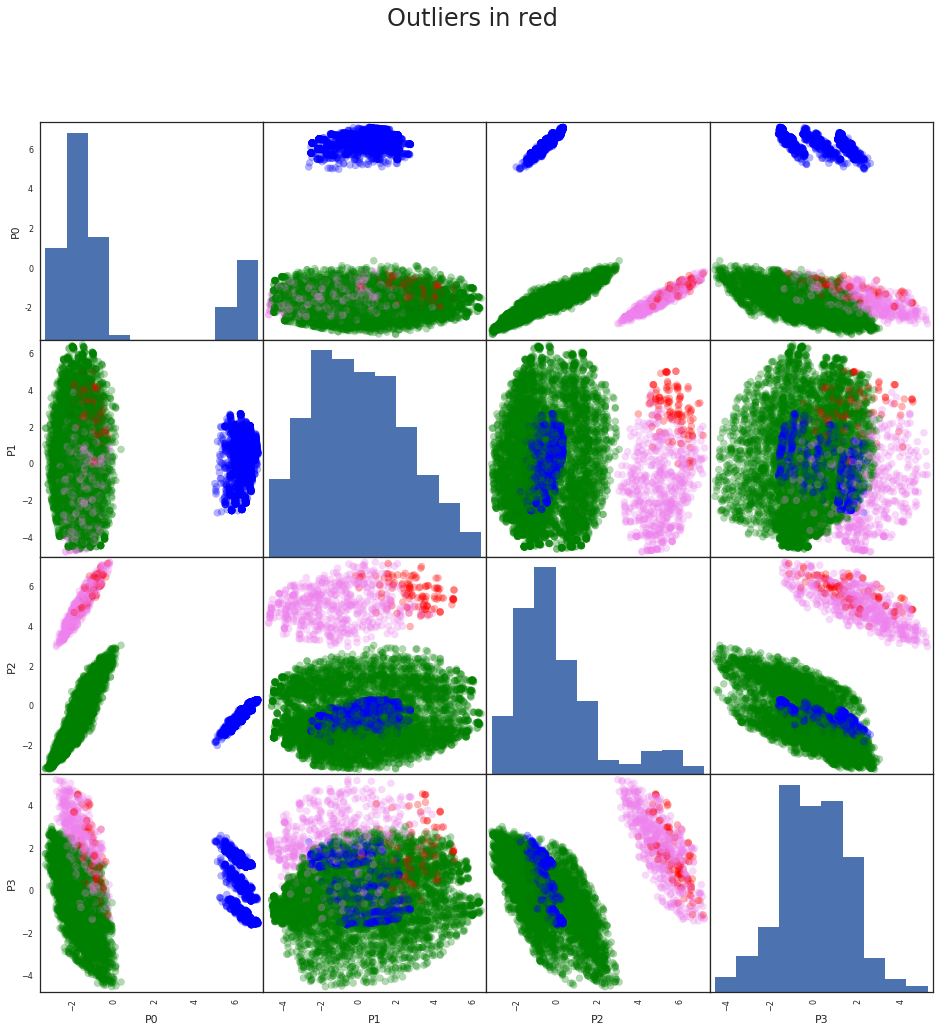

In [32]:
# Figure 2
# plot each cluster a different color so we can see what cluster number is associated with each blob
df2 = pcomps
#df2 = pcomps[pcomps['Churn'] == 1]

#control how many and order of scatter plots to compare
attributes = [0, 1, 2, 3]

# if we generate too many clusters we run out of colors to display them.
colors=['red', 'violet','green','blue', 'yellow', 'black', 'gray', 'white', 'orange']
#dbscan numbers clusters from -1 to some positive number, the negative ones I want to color red, I use lambda to do this
scatter_matrix(df2[attributes],figsize=[16,16],marker='o', alpha=.3, c=df2['dbsPCA'].apply(lambda x:colors[x+1]))
plt.suptitle("Outliers in red", fontsize = 24)
plt.show()

In [33]:
print('Outliers: {} '.format(  dbsPCA_hist.tolist().count(-1)) )
churn_encoded_stats = pd.DataFrame(churn_encoded_numeric[churn_encoded_numeric['dbsPCA']<0].describe())

Outliers: 117 


In [34]:
churn_encoded_stats
#churn_encoded_numeric.plot(kind='bar', title='Number of Unique Valuess', ylim=(0,10), figsize=(15, 5) )

,Contract0,Contract1,Contract2,Dependents0,Dependents1,DeviceProtection0,DeviceProtection1,DeviceProtection2,InternetService0,InternetService1,...,TechSupport1,TechSupport2,gender0,gender1,SeniorCitizen,MonthlyCharges,tenure,TotalCharges,Churn,dbsPCA
count,117.000000,117.000000,117.000000,117.000000,117.000000,117.000000,117.000000,117,117,117,...,117.000000,117,117.000000,117.000000,117.000000,117.000000,117.000000,117.000000,117.000000,117
mean,0.008547,0.282051,0.709402,0.324786,0.675214,0.170940,0.829060,0,1,0,...,0.829060,0,0.538462,0.461538,0.068376,54.902564,56.940171,3165.528904,0.008547,-1
std,0.092450,0.451934,0.455991,0.470309,0.470309,0.378076,0.378076,0,0,0,...,0.378076,0,0.500663,0.500663,0.253476,8.422286,17.850090,1147.871135,0.092450,0
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0,1,0,...,0.000000,0,0.000000,0.000000,0.000000,29.900000,0.000000,305.550000,0.000000,-1
25%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0,1,0,...,1.000000,0,0.000000,0.000000,0.000000,49.850000,48.000000,2317.100000,0.000000,-1
50%,0.000000,0.000000,1.000000,0.000000,1.000000,0.000000,1.000000,0,1,0,...,1.000000,0,1.000000,0.000000,0.000000,56.400000,65.000000,3281.650000,0.000000,-1
75%,0.000000,1.000000,1.000000,1.000000,1.000000,0.000000,1.000000,0,1,0,...,1.000000,0,1.000000,1.000000,0.000000,60.800000,71.000000,4122.650000,0.000000,-1
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0,1,0,...,1.000000,0,1.000000,1.000000,1.000000,67.200000,72.000000,4919.700000,1.000000,-1


# Comentary: On descriptive statitics 

When the number_of_eigens was set to 10, and the dbscan eps was set to 4.2 we arrive at one view of the churn_encoded_numeric dataframe.  In that particualr case the outliers, reflected by the dbsPCA cluster number = -1, show some interesting behavior.

Filtering the data to look at just outliers (dbsPCA = <0) exhibits interesting behaviors. Doing a describe on the data sllows us to look for patterns visually. What I look for are strange mean values or strange extremes for max or min. We see that P0 < 0 pertains specifically to the class where DeviceProtection2 has a value of 0 for all instances while InternetService0 has a value of 1. Also the Total_chrages seem higher than average. So lets explore that more.

So we are capturing some commonalities that all those in the outlier class exhibit.





# Examine Outliers Statistics Like This

In [35]:
pcomps.head()

,P0,P1,P2,P3,P4,P5,P6,P7,P8,P9,dbsPCA
0,-1.968681,-2.747834,4.725146,1.228740,2.765924,1.720818,-2.083150,-0.814524,1.572188,-1.193738,0
1,-0.278500,-0.978381,2.011451,-1.213233,-3.506086,-1.679280,1.104794,0.761665,1.070117,2.187840,1
2,-1.146662,-2.733011,1.029566,-1.132914,-2.202124,-1.290734,-0.724302,-2.139346,0.695458,-1.818325,1
3,-0.637056,0.063671,6.708676,1.973335,-1.558913,-1.457295,-0.460429,0.956567,0.170260,2.634067,0
4,-2.149675,-4.113140,-1.426856,-0.534737,-0.191631,1.443313,0.030788,-0.639509,-0.209442,0.150772,1


In [36]:
if 'dbsPCA' in pcomps.columns:
    pcomps.drop(['dbsPCA'], axis = 1, inplace=True)

churn_glued = pd.concat([churn_encoded_numeric, pcomps], axis=1)
churn_glued = (churn_glued - churn_glued.min(0)) / (churn_glued.max(0) -churn_glued.min(0))
if 'dbsPCA' in churn_glued.columns:
    churn_glued.drop(['dbsPCA'], axis = 1, inplace=True)
churn_glued = pd.concat([churn_glued,  churn_encoded_numeric['dbsPCA']], axis=1)
    
churn_glued.to_csv('churn_glued.csv')
churn_glued.head()


/usr/local/src/bluemix_jupyter_bundle.v95/notebook/lib/python2.7/site-packages/ipykernel/__main__.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  from ipykernel import kernelapp as app


,Contract0,Contract1,Contract2,Dependents0,Dependents1,DeviceProtection0,DeviceProtection1,DeviceProtection2,InternetService0,InternetService1,...,P1,P2,P3,P4,P5,P6,P7,P8,P9,dbsPCA
0,1,0,0,1,0,1,0,0,1,0,...,0.180795,0.762279,0.591690,0.767976,0.969430,0.250979,0.340013,0.689486,0.260762,0
1,0,1,0,1,0,0,1,0,1,0,...,0.338494,0.500987,0.340762,0.118845,0.037770,0.608738,0.574551,0.618194,0.751734,1
2,1,0,0,1,0,1,0,0,1,0,...,0.182116,0.406444,0.349015,0.253801,0.144236,0.403472,0.142879,0.564993,0.170078,1
3,0,1,0,1,0,0,1,0,1,0,...,0.431365,0.953266,0.668202,0.320371,0.098597,0.433085,0.603553,0.490417,0.816522,0
4,1,0,0,1,0,1,0,0,0,1,...,0.059115,0.169924,0.410482,0.461880,0.893391,0.488210,0.366056,0.436500,0.455972,1


# Use a two variable Bar Plot to Compare Descriptive Stats of Outliers to the General Population

Outliers: Blue

General: Red

Here we plot the values of the means of the various columns to see how Outliers compare to the General population

Notice that the outliers have prominent missing or zeros values in key columns. This means the outliers exibhit much different behavior than the gernal population.

They spend more, churn less, have strong perferences for InternetService0 and PhoneService0 without multuiple lines

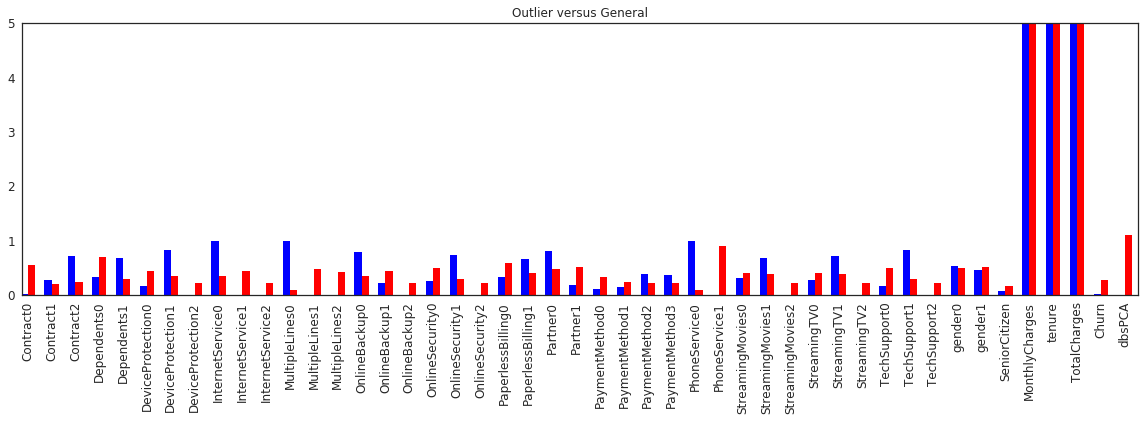

In [37]:
fig = plt.figure() # Create matplotlib figure

churn_outlier_stats = pd.DataFrame(churn_encoded_numeric[churn_encoded_numeric['dbsPCA']<0].describe() )
churn_general_stats = pd.DataFrame(churn_encoded_numeric.describe() )

ax = fig.add_subplot(111) # Create matplotlib axes
#ax2 = ax.twinx() # Create another axes that shares the same x-axis as ax.

width = .3
#df.amount.plot(kind='bar', color='red', ax=ax, width=width, position=1)
#df.price.plot(kind='bar', color='blue', ax=ax2, width=width, position=0)
churn_outlier_stats.loc['mean',:].plot(kind='bar', title='Outlier versus General', ylim=(0,5), figsize=[20,5], fontsize = 12, width = width, color = 'b', position = 1)
churn_general_stats.loc['mean',:].plot(kind='bar', ylim=(0,5), figsize=[20,5], fontsize = 12, width = width, color = 'r', position =0)

plt.show()

In [38]:
churn_outlier_stats.head()

,Contract0,Contract1,Contract2,Dependents0,Dependents1,DeviceProtection0,DeviceProtection1,DeviceProtection2,InternetService0,InternetService1,...,TechSupport1,TechSupport2,gender0,gender1,SeniorCitizen,MonthlyCharges,tenure,TotalCharges,Churn,dbsPCA
count,117.000000,117.000000,117.000000,117.000000,117.000000,117.000000,117.000000,117,117,117,...,117.000000,117,117.000000,117.000000,117.000000,117.000000,117.000000,117.000000,117.000000,117
mean,0.008547,0.282051,0.709402,0.324786,0.675214,0.170940,0.829060,0,1,0,...,0.829060,0,0.538462,0.461538,0.068376,54.902564,56.940171,3165.528904,0.008547,-1
std,0.092450,0.451934,0.455991,0.470309,0.470309,0.378076,0.378076,0,0,0,...,0.378076,0,0.500663,0.500663,0.253476,8.422286,17.850090,1147.871135,0.092450,0
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0,1,0,...,0.000000,0,0.000000,0.000000,0.000000,29.900000,0.000000,305.550000,0.000000,-1
25%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0,1,0,...,1.000000,0,0.000000,0.000000,0.000000,49.850000,48.000000,2317.100000,0.000000,-1


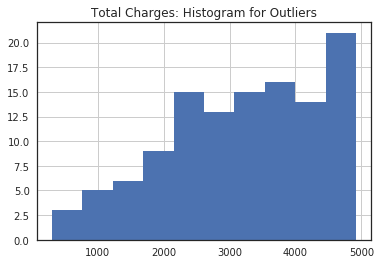

In [39]:
#churn_encoded_numeric[pcomps['dbsPCA']<0].head()
if 'Churn' not in churn_glued.columns:
    churn_glued = pd.concat([churn_encoded_numeric, label], axis=1)  # add numeric to main df
churn_glued[churn_glued['dbsPCA']<0]

plt.title('Total Charges: Histogram for Outliers')
Outliers = churn_encoded_numeric[churn_glued['dbsPCA']<0]['TotalCharges']
Outliers.hist()

## Comparing Outlier to the general population

Comparing the outliers we identified and graphed above, we see that outlier total charges tend to be concnetrated above $2000 which means the Telco has generated lots of revenue fro these customers

The general population below mostly has spent much less than $2000

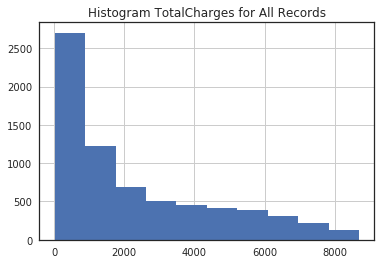

In [40]:
plt.title('Histogram TotalCharges for All Records')
GeneralPop = churn_encoded_numeric['TotalCharges']
GeneralPop.hist()

# Descriptive Statistics of Outliers

Below we shall describe the subset of the population we uncovered as outliers.

Do you see any trends? Look at each column and identify columns that have a very low or very high mean. Especially, look for columns with a mean of 0 or 1. These values indicate that the entire column has a single through every instance. Also, look for any means that differ significantly from the general population.

In [41]:
churn_glued[churn_glued['dbsPCA']<0].describe()

,Contract0,Contract1,Contract2,Dependents0,Dependents1,DeviceProtection0,DeviceProtection1,DeviceProtection2,InternetService0,InternetService1,...,P1,P2,P3,P4,P5,P6,P7,P8,P9,dbsPCA
count,117.000000,117.000000,117.000000,117.000000,117.000000,117.000000,117.000000,117,117,117,...,117.000000,117.000000,117.000000,117.000000,117.000000,117.000000,117.000000,117.000000,117.000000,117
mean,0.008547,0.282051,0.709402,0.324786,0.675214,0.170940,0.829060,0,1,0,...,0.687630,0.852459,0.631940,0.618639,0.553329,0.517858,0.507945,0.496148,0.359108,-1
std,0.092450,0.451934,0.455991,0.470309,0.470309,0.378076,0.378076,0,0,0,...,0.106950,0.062736,0.134373,0.150533,0.388971,0.143673,0.185513,0.194859,0.169612,0
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0,1,0,...,0.410319,0.689415,0.347116,0.256633,0.071062,0.182353,0.150211,0.136570,0.017747,-1
25%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0,1,0,...,0.631287,0.808849,0.542346,0.540275,0.139673,0.436131,0.300325,0.390093,0.247013,-1
50%,0.000000,0.000000,1.000000,0.000000,1.000000,0.000000,1.000000,0,1,0,...,0.696901,0.850548,0.627015,0.648411,0.866063,0.532976,0.594893,0.456004,0.326906,-1
75%,0.000000,1.000000,1.000000,1.000000,1.000000,0.000000,1.000000,0,1,0,...,0.751590,0.893066,0.705016,0.719040,0.909680,0.610965,0.645714,0.573163,0.492320,-1
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0,1,0,...,0.872612,0.994376,0.931363,0.951116,0.974295,0.854121,0.744858,0.979981,0.837358,-1


# Using a Heatmap to view the entire data set

This works for toy datasets and for real world feature engineered datasets where a date range and subset of colulmns might be chosen to make visualization managable.

In real world data sometime this make sense anyway - limit a dataset view to just this years product feature set and maybe a single quarters worth of data. The value of this visual is in sorting columns to see how columns vary with one another. This type of plot allows me to view the entire dataset in one single view and observe patterns as I sort different columns

For example, play with the different between the heatmap NOT sorted sersus one sorted against P0

bobHeatmap(churn_glued, ' ')

bobHeatmap(churn_glued, 'P0')

The P0 cariable is the longest axis in a PCA plot - it expresses the most statstical variability i the dataset, which is kind of like saying if I had only one variable with which to describe my data the P0 would be the smart choice.

The legend of the graph is not idea, it seems to show values ranging from 0 (black) to 2(white) when the data itself is completely described by a range of values form 0 to 1 (black to red). Continuous variable such as MonthlyCharges or P0 generally gradually blend and seems muted when sorted randomly. Categorical values are represetned as being either on or off, 0 or 1, and are therefor plotted as black (0), or fiery red (1).

Vertical or horizontal patterns that the eye picts out have meaning. Horizontal banding means some columns are better correlated at least over a range of values.
Vertical stripes of red or black indicate that the rows or customer ID's are behaving in a very similar way for longer stretches

Careful examplination and "What If" questions begin to really draw insight out of these heatmaps and they begin to reveal patterns of behavior of the customers - as either forced upon them by product marketing decisions (certain contracts and packages are only ever bundled together), or are expressions of customers decisions such as staying or leaving (churn), tenure, monthly charges, which plan they selected etc


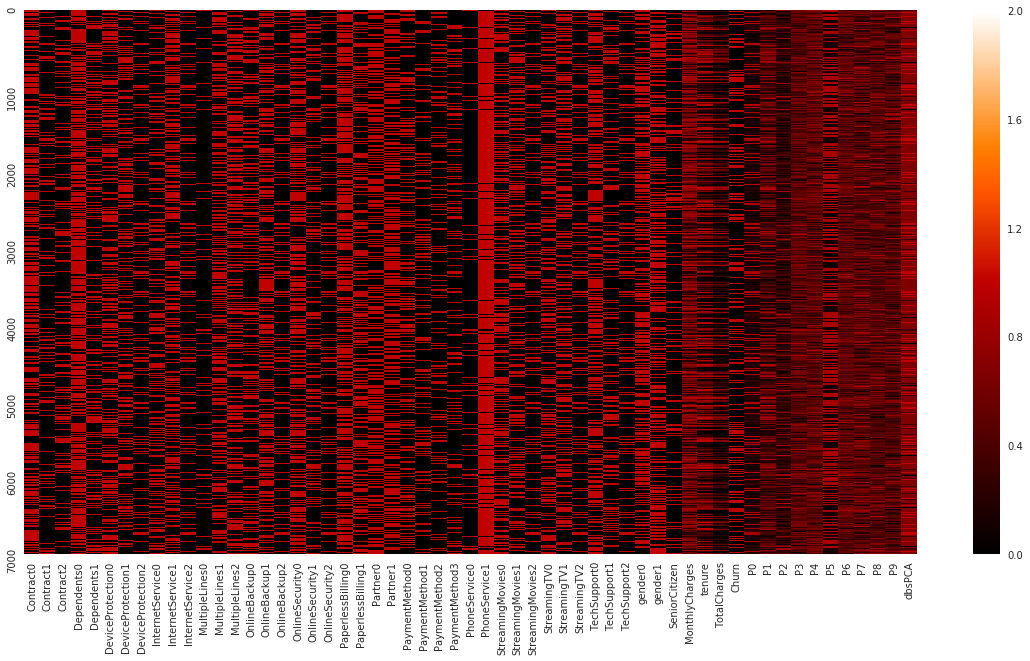

In [57]:
bobHeatmap(churn_glued, '')

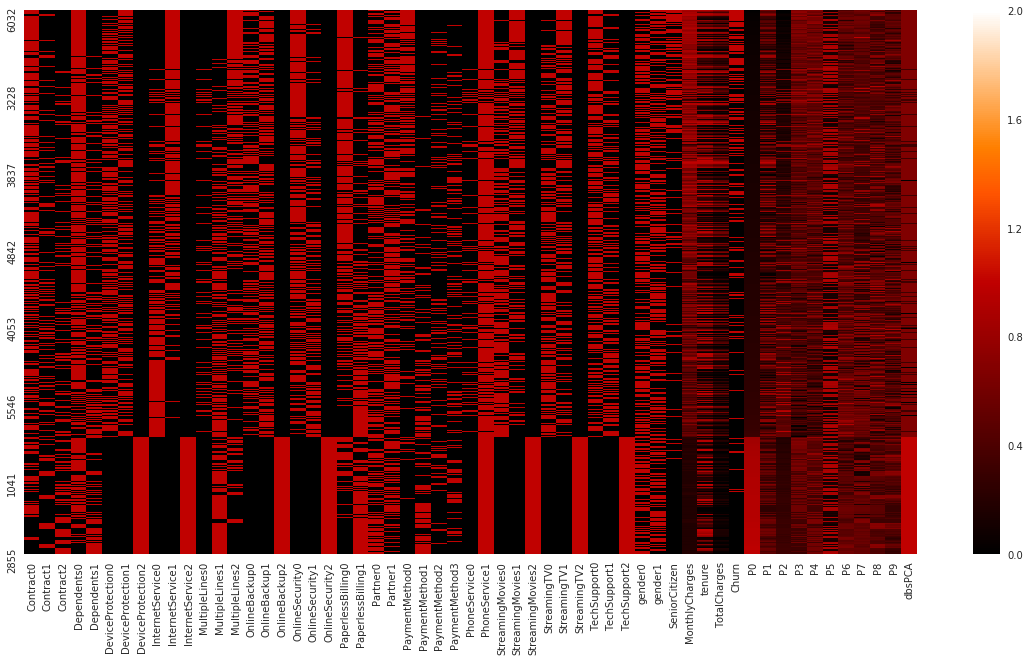

In [66]:
bobHeatmap(churn_glued, 'P0')

# Modeling

## Split Data - Training/Test

Splitting the data can be a very easy thing but its also easy to get into trouble.

We want to ensure that in subsequent runs we never contaminate the test set from run to run. Using a random seed help something like randseed = 42

But if we ever drop or add rows, and then use the same random selection we will likely wind up putting a new value into our test set inadvertantly.

It would be best to split the data based on some invariant such as a hask of column names or some other unique row identifier. But for now we take the easy random split approach.

In [44]:
# to make this notebook's output identical at every run
np.random.seed(42)
# For illustration only. Sklearn has train_test_split()
def split_train_test(data, test_ratio):
    shuffled_indices = np.random.permutation(len(data))
    test_set_size = int(len(data) * test_ratio)
    test_indices = shuffled_indices[:test_set_size]
    train_indices = shuffled_indices[test_set_size:]
    return data.iloc[train_indices], data.iloc[test_indices]

def split_train_test2(data, labels, test_ratio):
    shuffled_indices = np.random.permutation(len(data))
    test_set_size = int(len(data) * test_ratio)
    test_indices = shuffled_indices[:test_set_size]
    train_indices = shuffled_indices[test_set_size:]
    return data.iloc[train_indices], data.iloc[test_indices], labels.iloc[train_indices], labels.iloc[test_indices]

churn_encoded_numeric
churn_scaled = pd.concat([churn_cat['customerID'], churn_encoded_numeric], axis=1)
churn_scaled.head()
#if ( len(churn_scaled.customerID.unique()) ==  len(churn_encoded_numeric)) : print "Unique Identifier"



,customerID,Contract0,Contract1,Contract2,Dependents0,Dependents1,DeviceProtection0,DeviceProtection1,DeviceProtection2,InternetService0,...,TechSupport1,TechSupport2,gender0,gender1,SeniorCitizen,MonthlyCharges,tenure,TotalCharges,Churn,dbsPCA
0,7590-VHVEG,1,0,0,1,0,1,0,0,1,...,0,0,1,0,0,29.85,1,29.850000,0,0
1,5575-GNVDE,0,1,0,1,0,0,1,0,1,...,0,0,0,1,0,56.95,34,1889.500000,0,1
2,3668-QPYBK,1,0,0,1,0,1,0,0,1,...,0,0,0,1,0,53.85,2,2284.431783,1,1
3,7795-CFOCW,0,1,0,1,0,0,1,0,1,...,1,0,0,1,0,0.00,45,1840.750000,0,0
4,9237-HQITU,1,0,0,1,0,1,0,0,0,...,0,0,1,0,0,70.70,2,2284.431783,1,1


# First Model - Decision Tree

Use churn_scaled dataframe which is a more minimally processed version of our raw data - all numeric, but no pca at this point.

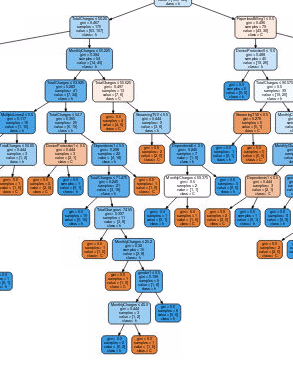

In [45]:
X = churn_encoded_numeric
train_set, test_set = split_train_test(X, 0.2)

accuracy: 0.796164772727


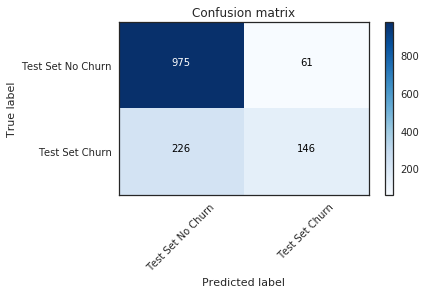

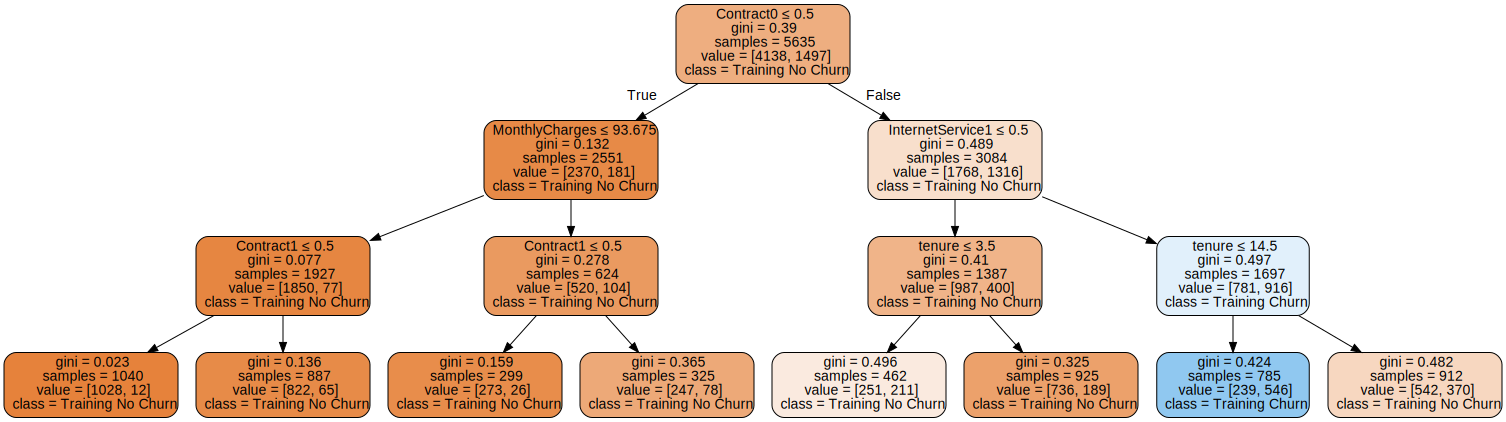

In [46]:
from sklearn.tree import DecisionTreeClassifier 
from sklearn.model_selection import cross_val_score
from sklearn.metrics import accuracy_score
from sklearn import tree
import graphviz
from sklearn.metrics import confusion_matrix

clf = DecisionTreeClassifier(random_state=42, max_depth = 3)
AllCols = X.columns
StaticCols = ['Churn','dbsPCA']

dataCols = (list(set(AllCols) - set(StaticCols)))
clf = clf.fit(train_set[dataCols], train_set['Churn'])
#accuracy = cross_val_score(clf, churn_cat_encode_new2[dataCols], churn_cat_encode_new2['Churn'], cv=10)
predicted = clf.predict(test_set[dataCols])
print "accuracy: {}".format(accuracy_score(test_set['Churn'], predicted ) )

dot_data = tree.export_graphviz(clf, out_file=None) 
graph = graphviz.Source(dot_data) 
dot_data = tree.export_graphviz(clf, out_file=None, 
                         feature_names=dataCols,  
                         class_names=['Training No Churn','Training Churn'],
                         filled=True, rounded=True,  
                         special_characters=True) 
graph.render("Churn")   #to copy to pdf
graph = graphviz.Source(dot_data) 
graph.render("TreeModel")
graph   #churners orange, non chutners blue


class_names =  ['Test Set No Churn','Test Set Churn']  
cnf_matrix = confusion_matrix(test_set['Churn'], predicted)

plot_confusion_matrix(cnf_matrix, class_names)
graph

## Confusion plot matrix

The confusion matrix is a data science term used to describe the nature of true versus false positives and negative results. Here it is implemended as a heatamp. The diagonal major axis expresses our accuracy, while the off diagonal indicates how our model mispredicted by erroring on false positives or negatives.

Wikipedia has a nice writeup of confusion matrix here: https://en.wikipedia.org/wiki/Confusion_matrix

## Comprehending the decision tree diagram

Decision trees are one of the more human readable models out there and it pairs nicely with atree diagram as depicted above.

Playing with a tree diagram is the best way to learn how to read it. See if you can describe the path it takes to find the most Churners, by selecting Contract0, InternetService1, and tenure. Can you specify the trhreshold values used for these columns in order to find the highest churn density?

Follow the tree from the top and modify the query below to match the cloumns/conditions you observe in the tree

This should give you a sense of how you can filter your data to observe behaviors associated with the most concentrated pockets of Churners (blue) or Non Churners (orange) in this case.

If you want to increase your odds of finding non-churners direct your query more to the dark orange leaf nodes. To experiment with high likelihood churners point your attention to the darkest blue boxes.

Answer: Contract0 == 1, InternetService1 == 1, tenure <= 14.5 --> finds 546 out of 785 samples to be churners which is about a 69% chance of finding a churner.
had we just drawn randomly for the entire data set our chances of finding a churner would only have been 1497/5635 ~ 26.5%

Overall, this decision tree model, in aggregate, acheived a 79% - 80% accuracy

In [47]:
# look for the Lowest density of Churners in the graph above - see if you can find the 12 churners out of 1040 samples by using boolean logic applied to coulmns and using the thresholds identified in the graph
q = (train_set['Contract0'] < 0.5) & (train_set['MonthlyCharges']< 93.675) & (train_set['Contract1'] <= 0.5)
print "total number of customers in this sub population: {}".format(len(train_set[q]))
print "Churners in this sub population: \t\t  {}".format(  (train_set[q]['Churn'] ==1).sum()  )
print "Non Churners in this sub population: \t\t  {}".format(  (train_set[q]['Churn'] < 1).sum()  )

total number of customers in this sub population: 1040
Churners in this sub population: 		  12
Non Churners in this sub population: 		  1028


# Second Model Neural Network in Tensofrflow (Fully Connected Layers)

Now we can begin exploring using Tensorflow to model a Deep Neural Network of fully connected layers as a churn classifier. Little effort has been applied to select the best hyperparameters here. This netork is using ONLY the categorical values becuase including MonthlyCharges and TotalCharges lowers the accuracy.  Perhaps binning these continuous variables is an option or perhaps using the standardized data across the board with a different loss function would be next steps to try.

In [48]:
X = churn_encoded_numeric.apply(np.int32)
train_set, test_set = split_train_test(X, 0.2)
AllCols = X.columns
# remove the numeric columns, to see how accurately just categorical columns predict
# remove Churn because that is waht we are trying to predict
StaticCols = ['Churn', 'MonthlyCharges', 'TotalCharges']
dataCols = sorted(list(set(AllCols) - set(StaticCols)))

CLASS_SIZE = 2
DATA_SIZE = len(dataCols)

xdata, xtest  = split_train_test( X, 0.2)
y_data = np.array(xdata['Churn'])
y_test = np.array(xtest['Churn'])
x_data = np.array(xdata[dataCols])
x_test = np.array(xtest[dataCols])

#x_data, x_test, y_data, y_test = split_train_test2( X[dataCols], X['Churn'], 0.2)

x_train = np.array(x_data)
y_train = np.array(y_data)
x_test = np.array(x_test)
y_test = np.array(y_test)

Accuracy: 0.800426
Predictions: [0 0 0 ... 0 0 0]


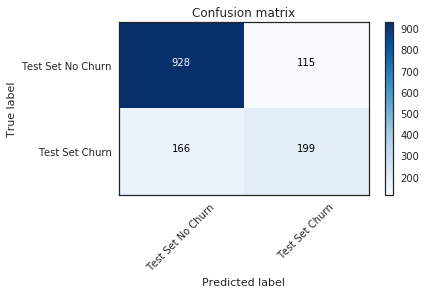

In [49]:
from sklearn.metrics import confusion_matrix

# Build 3 layer DNN with 10, 30, 10 units respectively.
# classifier = Classifier(hidden_units=[10,10,10] n_classes = 2, data_size = len(dataCols))
classifier = Classifier(hidden_units=[10,30,10], n_classes = 2, data_size = len(dataCols))

# Fit model. steps=1200
classifier.fit(x_train, y_train, steps=1200)

# Evaluate accuracy.
accuracy_score = classifier.evaluate(x_test, y_test)[0]
print('Accuracy: {0:f}'.format(accuracy_score))

# Classify two new flower samples.
y_pred = classifier.predict(x_test)
#print (y > .5).sum()
print ('Predictions: {}'.format(str(y_pred)))

class_names =  ['Test Set No Churn','Test Set Churn']     
cnf_matrix = confusion_matrix(y_test, y_pred)

plot_confusion_matrix(cnf_matrix, class_names)

# Experiment with Linear Discriminant Analysis LDA
Note: this is not the same as Latent Dirichlet Allocation used in NLP tasks for factoring into Document/Term matrix
This is a supervised learning technique that is similar to PCA in that it tries to maximize the variance of the known classes

/gpfs/fs01/user/s37a-6a8375ad9b78b5-6459f7095f24/.local/lib/python2.7/site-packages/sklearn/discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")


accuracy: 0.781960227273


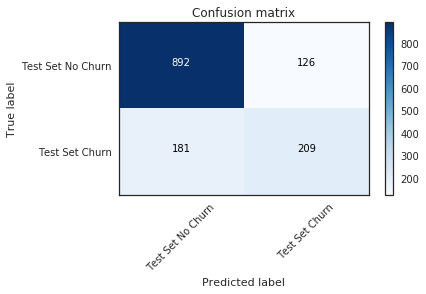

In [50]:
# Load libraries
from sklearn import datasets
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.model_selection import cross_val_score
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix

X = churn_glued.apply(np.int32)
train_set, test_set = split_train_test(X, 0.2)
AllCols = X.columns

PredictedLabel = 'Churn'

# Create an LDA that will reduce the data down to 1 feature
lda = LinearDiscriminantAnalysis(n_components=4)

#clf = DecisionTreeClassifier(random_state=42, max_depth = 3)
AllCols = X.columns
StaticCols = [PredictedLabel,'dbsPCA']

dataCols = (list(set(AllCols) - set(StaticCols)))
lda = lda.fit(train_set[dataCols], train_set[PredictedLabel])

# run an LDA and use it to transform the features
X_lda = lda.transform(train_set[dataCols])

#accuracy = cross_val_score(clf, churn_cat_encode_new2[dataCols], churn_cat_encode_new2['Churn'], cv=10)
predicted = lda.predict(test_set[dataCols])
print "accuracy: {}".format(accuracy_score(test_set['Churn'], predicted ) )


class_names =  ['Test Set No Churn','Test Set Churn']  
cnf_matrix = confusion_matrix(test_set['Churn'], predicted)

plot_confusion_matrix(cnf_matrix, class_names)


In [51]:
LDA = pd.DataFrame (lda.transform(X[dataCols]), columns=['LDA'])

In [52]:
churn_glued2= pd.concat([churn_glued, LDA], axis = 1)

In [53]:
churn_glued2.head()

,Contract0,Contract1,Contract2,Dependents0,Dependents1,DeviceProtection0,DeviceProtection1,DeviceProtection2,InternetService0,InternetService1,...,P2,P3,P4,P5,P6,P7,P8,P9,dbsPCA,LDA
0,1,0,0,1,0,1,0,0,1,0,...,0.762279,0.591690,0.767976,0.969430,0.250979,0.340013,0.689486,0.260762,0,0.813188
1,0,1,0,1,0,0,1,0,1,0,...,0.500987,0.340762,0.118845,0.037770,0.608738,0.574551,0.618194,0.751734,1,-1.072448
2,1,0,0,1,0,1,0,0,1,0,...,0.406444,0.349015,0.253801,0.144236,0.403472,0.142879,0.564993,0.170078,1,-0.109249
3,0,1,0,1,0,0,1,0,1,0,...,0.953266,0.668202,0.320371,0.098597,0.433085,0.603553,0.490417,0.816522,0,-1.365640
4,1,0,0,1,0,1,0,0,0,1,...,0.169924,0.410482,0.461880,0.893391,0.488210,0.366056,0.436500,0.455972,1,1.837487


# LDA Varies in Different Ways from PCA

LDA seems to predict almost as well as other methods and has different explainability - notice which columns co-vary with the LDA column which is the last column in the heatmap.

From the below heatmap it seems that LDA model is more senstitive to the contract0, contract1, comntract2, DeviceProtection2, OnlineBackup, StreamingMovies2, TechSupport2 among other columns (as seen by the vertical bar portions in the lower part of the heatmap)

### from Wikipedia on LDA ...
Linear discriminant analysis (LDA), normal discriminant analysis (NDA), or discriminant function analysis is a generalization of Fisher's linear discriminant, a method used in statistics, pattern recognition and machine learning to find a linear combination of features that characterizes or separates two or more classes of objects or events. The resulting combination may be used as a linear classifier, or, more commonly, for dimensionality reduction before later classification. 

LDA is closely related to analysis of variance (ANOVA) and regression analysis, which also attempt to express one dependent variable as a linear combination of other features or measurements.[1][2] However, ANOVA uses categorical independent variables and a continuous dependent variable, whereas discriminant analysis has continuous independent variables and a categorical dependent variable (i.e. the class label).[3] Logistic regression and probit regression are more similar to LDA than ANOVA is, as they also explain a categorical variable by the values of continuous independent variables. These other methods are preferable in applications where it is not reasonable to assume that the independent variables are normally distributed, which is a fundamental assumption of the LDA method. 

LDA is also closely related to principal component analysis (PCA) and factor analysis in that they both look for linear combinations of variables which best explain the data.[4] LDA explicitly attempts to model the difference between the classes of data. PCA on the other hand does not take into account any difference in class, and factor analysis builds the feature combinations based on differences rather than similarities. Discriminant analysis is also different from factor analysis in that it is not an interdependence technique: a distinction between independent variables and dependent variables (also called criterion variables) must be made. 

LDA works when the measurements made on independent variables for each observation are continuous quantities. When dealing with categorical independent variables, the equivalent technique is discriminant correspondence analysis.[5][6] 

Discriminant analysis is used when groups are known a priori (unlike in cluster analysis). Each case must have a score on one or more quantitative predictor measures, and a score on a group measure.[7] In simple terms, discriminant function analysis is classification - the act of distributing things into groups, classes or categories of the same type. 

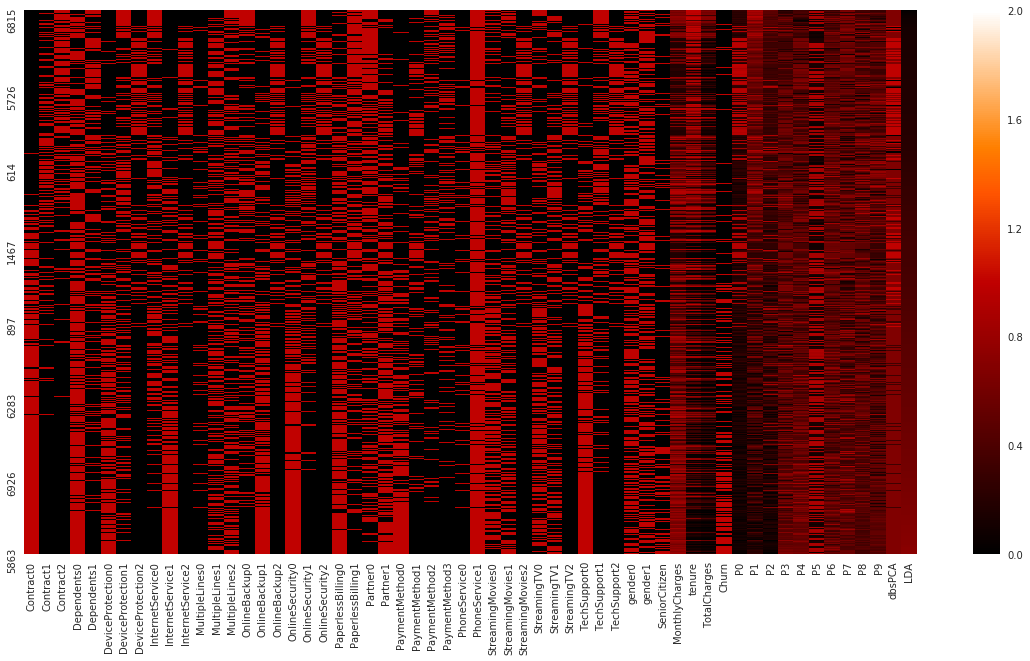

In [54]:
bobHeatmap(churn_glued2,'LDA')